# ノート 4: 単純な ML による分類

### 目標: 1 つの特徴量（予測変数、入力変数）と 1 つの ML モデルを用いて ML による学習の基礎を身につける

### 問題設定の確認

1. 各画像は雷雲を含んでいるか（分類問題）
2. 各画像にはいくつの発雷があるか（回帰問題）

### 背景

このチュートリアルでは ML のパッケージである scikit-learn を利用します。
scikit-learn は様々な ML 手法を学ぶのに適したツールが豊富に用意されているだけでなくドキュメントも充実しています。
チュートリアルの内容からさらに進んで利用したいと思ったらぜひドキュメントを読んでみてください。

scikit-learn を使うメリットは異なる ML モデルでも同じコードの形で実行できることです。基本的な手順は次のとおりです。

1. 入力データを `[サンプル数, 特徴量数]` の形状で用意します。scikit-learn のドキュメントでは `X` で表される変数です。
2. 出力データを `[サンプル数]` の形状で用意します。ドキュメントでは `y` で表される変数です。
3. モデル名のクラスのインスタンスを作成し初期化します。初期化時にハイパーパラメータを指定することができます。
4. モデルインスタンスの `.fit(X, y)` メソッドを実行しモデルの学習を行います。
5. 学習モデルの評価を行います。評価データからの予測は `.predict(X_val)` または `.predict_proba(X_bal)`メソッドを実行します。

基本的な流れがイメージできたでしょうか？入力変数が 1 つの簡単な例で ML を行ってみましょう。まずは分類問題からです。


### Step 1 & 2: パッケージのインポートと分類問題用のデータの読み込み

ノート 3 で訓練、検証、テストデータの分割方法を学び、ノートの最後でユーティリティ関数を使って分割済みデータセットの読み込みを行いました。
このノートでは特徴量を 1 つだけを使うので `features_to_keep` 引数の値を変えてデータを読み込みましょう。


In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df


In [2]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 1, 1),  # 1番目の特徴量（IR 画像の最低輝度温度）だけ
    class_labels=True,
)

形状 `[n_samples,n_features]` の`X` と 形状 `[n_samples]`の `Y` が読み込めているか確認しましょう。


In [3]:
print("X_train, y_train shapes: {},{}".format(X_train.shape, y_train.shape))
print("X_val, y_val shapes: {},{}".format(X_validate.shape, y_validate.shape))
print("X_test, y_test shapes: {},{}".format(X_test.shape, y_test.shape))

X_train, y_train shapes: (446320, 1),(446320,)
X_val, y_val shapes: (82871, 1),(82871,)
X_test, y_test shapes: (89718, 1),(89718,)


`X` と `Y` の`n_samples` が分割したそれぞれのデータで等しく `X` の形状は `[n_samples,n_features]` になっています。
論文の図 8 を作成して IR 画像の最低輝度温度から発雷がどの程度予測できるのか示してみましょう。

まず、各サンプルが発雷を含むか含まないかを調べる必要があります。
`np.where` メソッドを用いてラベルが 1（発雷あり） になっている`X`, `y` のインデックスを求めましょう。
`load_n_combine_df` でデータを読み込むときに `class_labels=True` としたので
得られた `y` には各サンプル画像に発雷が含まれない場合は 0、1 つ以上含まれている場合は 1 がラベル付けされています。


In [4]:
# 発雷あり（yのラベルが1）のインデックス
idx_flash = np.where(y_train == 1)[0]
# 発雷なし（yのラベルが0）のインデックス
idx_noflash = np.where(y_train == 0)[0]

ヒストグラムでも確かめてみましょう。


Text(0.5, 1.0, 'No Flash')

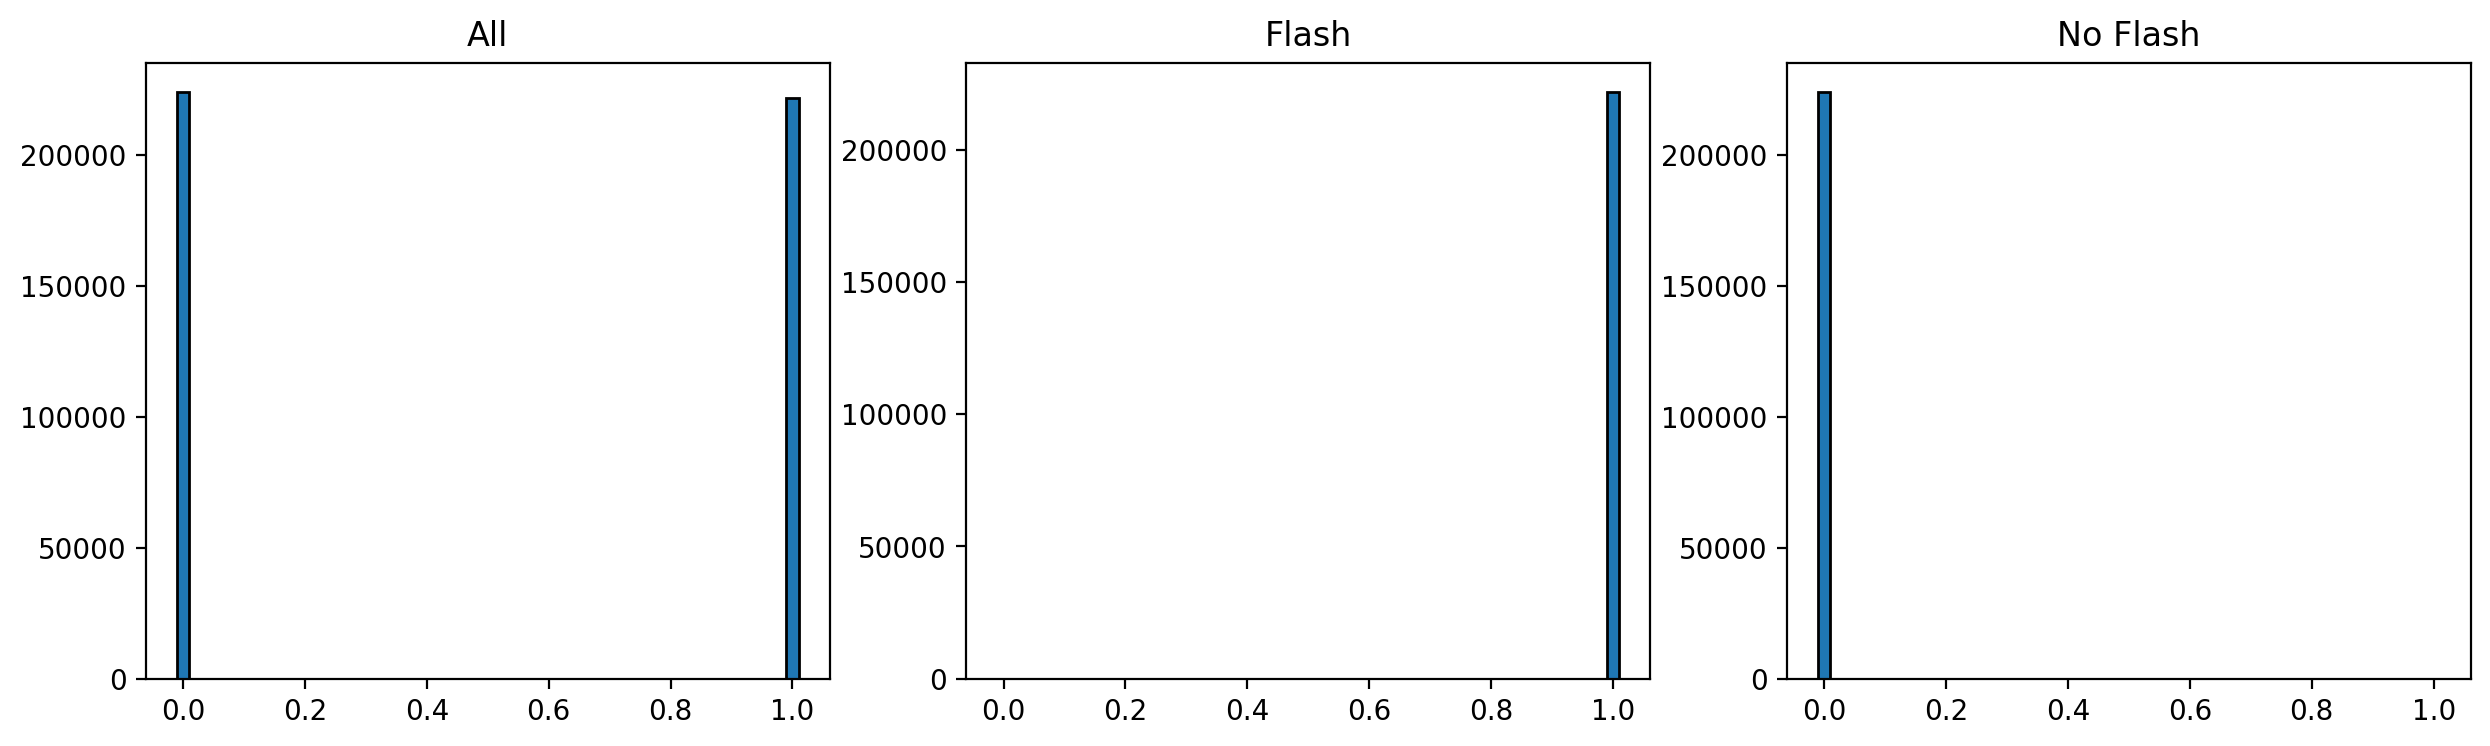

In [5]:
_, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=[-0.01, 0.01, 0.99, 1.01], edgecolor="k")
axes[0].set_title("All")

axes[1].hist(y_train[idx_flash], bins=[-0.01, 0.01, 0.99, 1.01], edgecolor="k")
axes[1].set_title("Flash")

axes[2].hist(y_train[idx_noflash], bins=[-0.01, 0.01, 0.99, 1.01], edgecolor="k")
axes[2].set_title("No Flash")

次は輝度温度のヒストグラムを描いてみましょう。発雷を含む事例の画像にはより背の高い積乱雲が含まれていることが期待できるので、
最低輝度温度は低くなっていると予想できます。


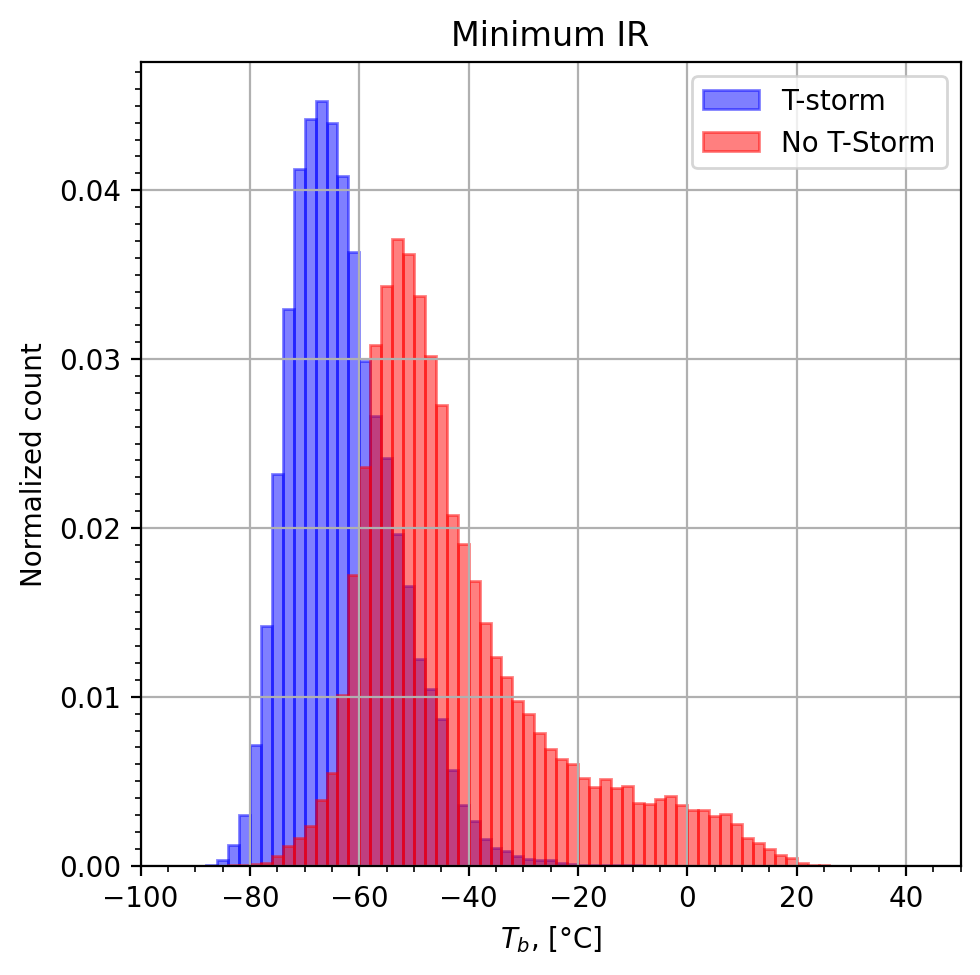

In [6]:
from matplotlib.ticker import MultipleLocator

# ヒストグラムの分割幅
xbins = np.arange(-100, 50, 2)

fig, ax = plt.subplots(figsize=(5, 5))

# 発雷あり
ax.hist(
    X_train[idx_flash, 0],
    density=True,
    bins=xbins,
    color="b",
    alpha=0.5,
    zorder=0,
    label="T-storm",
    edgecolor="b",
)
# 発雷なし
ax.hist(
    X_train[idx_noflash, 0],
    density=True,
    bins=xbins,
    color="r",
    alpha=0.5,
    zorder=0,
    label="No T-Storm",
    edgecolor="r",
)

# タイトルやラベルの設定
ax.set_title("Minimum IR")
ax.set_ylabel("Normalized count")
ax.set_xlabel(r"$T_{b}$, [$\degree$C]")
# 軸ラベル
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))
# 描画範囲
ax.set_xlim([-100, 50])
# グリッドを表示
ax.grid("on")
# 凡例
ax.legend()

plt.tight_layout()

予想したような分布になったでしょうか。発雷ありとなしでは重なっている領域がありますが 2 つのクラスを分ける境界はありそうです。
ロジスティック回帰による ML から始めましょう。


### Step3: モデルの初期化

モデル名のクラスのインスタンスを作成することでモデルの初期化を行います。
モデルの初期化の際には様々なハイパーパラメータを選択できます。
特に背景知識がない場合は引数なしでモデルを初期化してデフォルトのハイパーパラメータを使うことが多いです。


In [7]:
# ロジスティック回帰のモデルクラスの読み込み
from sklearn.linear_model import LogisticRegression

# 初期化
model = LogisticRegression()
print(model)

LogisticRegression()


### Step 4: モデルを学習させよう

さあ、いよいよモデルを学習させるステップです。


In [8]:
model = model.fit(X_train, y_train)

これで学習は終了です。学習させたモデルで検証データからの予測をしてみましょう。`model.predict()`メソッドを使って検証データの `X` を予測変数にとして実行するだけです。


In [9]:
yhat = model.predict(X_validate)

予測値のベクトルを $\hat{y}$ と書くことにします。このベクトルは検証データの各サンプルのラベル（発雷のあり、なし）になっているので、ヒストグラムを描画したり様々な指標の計算に使うことができます。


#### a) 分割表: 正解率

予測結果の情報を得るために分割表を作成しましょう。

|     | Yes         | No          |
| --- | ----------- | ----------- |
| Yes | 的中 (TP)   | 誤検出 (FP) |
| No  | 見逃し (FN) | 空振り (TN) |

左列がモデルの予測、上段が観測（ラベルの真値）です。各セルを以下のように分割して埋めていきます。

- モデルと観測がともに Yes（model=obs=1 の場合、的中 または **True Positive** と言います）
- モデルは Yes だが観測が No の場合（model=1, obs=0 の場合、誤検出 または **False Positive** と言います）
- モデルは No だが観測が Yes の場合（model=0, bos=1 の場合、見逃し または **False Negative** と言います）
- モデルと観測がともに No（model=bos=0 の場合、Correct Null または **True Negative** と言います）

分割表を求めるために `gewriiter_function.py` からユーティリティ関数 `get_contingency_table` をインポートしましょう。
どのように計算しているかはコードを確認してください。


In [10]:
from gewitter_functions import get_contingency_table

# 検証データのラベル（真値）と予測値のラベルから分割表を作成
cont_table = get_contingency_table(yhat, y_validate)
# 返り値は辞書
pprint(cont_table)

{'num_false_negatives': 9695,
 'num_false_positives': 6353,
 'num_true_negatives': 30453,
 'num_true_positives': 36370}


分割表が作成できました。分割表から正解率

\begin{equation}
Accuracy = \frac{TP + TN}{N} \times{100}
\end{equation}

を求めてみましょう。コードを便利にするため、正解率を求めるユーティリティ関数 `get_accuracy` をインポートします。


In [11]:
from gewitter_functions import get_acc

accuracy = get_acc(cont_table)
print("Accuracy = {}%".format(np.round(accuracy, 0)))

Accuracy = 81.0%


正解率 81%は 1 変数の入力から得られる予測としてはよい値といえるでしょう。
論文でも述べていますが予測の評価は常に複数の指標で行うようにしましょう。


#### b) 分割表: パフォーマンスダイアグラム

分類問題の予測評価でよく用いられる指標にパフォーマンスダイアグラム（POD-SR ダイアグラム）があります。
ダイアグラムの右上ほどよい予測、左下ほど悪い予測であることを表します。

ダイアグラムを作成するためには 2 つの指標が必要です。1 つは的中率（POD、y 軸）、
もう一つは成功率（1-空振り率）(SR、x 軸)です。それぞれ以下の式で定義されます。

$$ POD = \frac{TP}{TP + FN} $$

$$ SR = \frac{TP}{TP + FP} $$

このダイアグラムのもう一つの利点はスレットスコア（TS、または Critical Success Index: CSI）
を表現できるという点です。CSI は以下で定義され、ダイアグラムの着色部分で図示されます。

$$ CSI = \frac{TP}{TP + FP + FN} $$

データに偏りがある場合に ML の結果を評価するのに役立つのもパフォーマンスダイアグラムの利点です。
例えば竜巻のように予測しようとする現象の頻度が低い場合が、データの偏りの一つの例になります。
頻度の低い現象の場合は Null（TN）の場合が非常に多くなり、TN を計算に使う指標（正解率など）は過大となる場合があります。

POD、SR、CSI を分割表から計算するユーティリティ関数をインポートして計算しましょう。


In [12]:
from gewitter_functions import get_pod, get_sr, csi_from_sr_and_pod

pod = get_pod(cont_table)
sr = get_sr(cont_table)
csi = csi_from_sr_and_pod(sr, pod)

print(
    "POD:{}, SR:{}, CSI:{}".format(np.round(pod, 2), np.round(sr, 2), np.round(csi, 2))
)

POD:0.79, SR:0.85, CSI:0.69


必要な指標が計算できました。ダイアグラムにプロットしてみましょう。
パフォーマンスダイアグラムの枠を作成するユーティリティ関数をインポートして描画してみましょう。


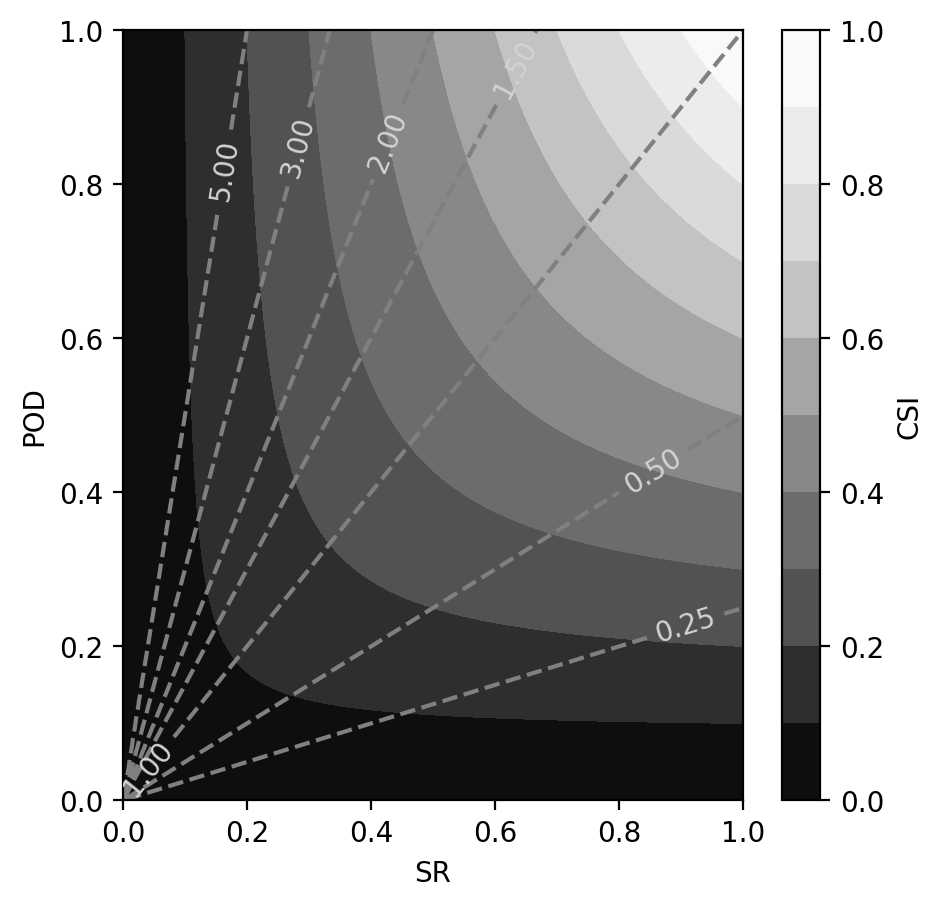

In [13]:
from gewitter_functions import make_performance_diagram_axis

ax = make_performance_diagram_axis()

`Axes` オブジェクトを使ってデータをダイアグラム上にプロットします。


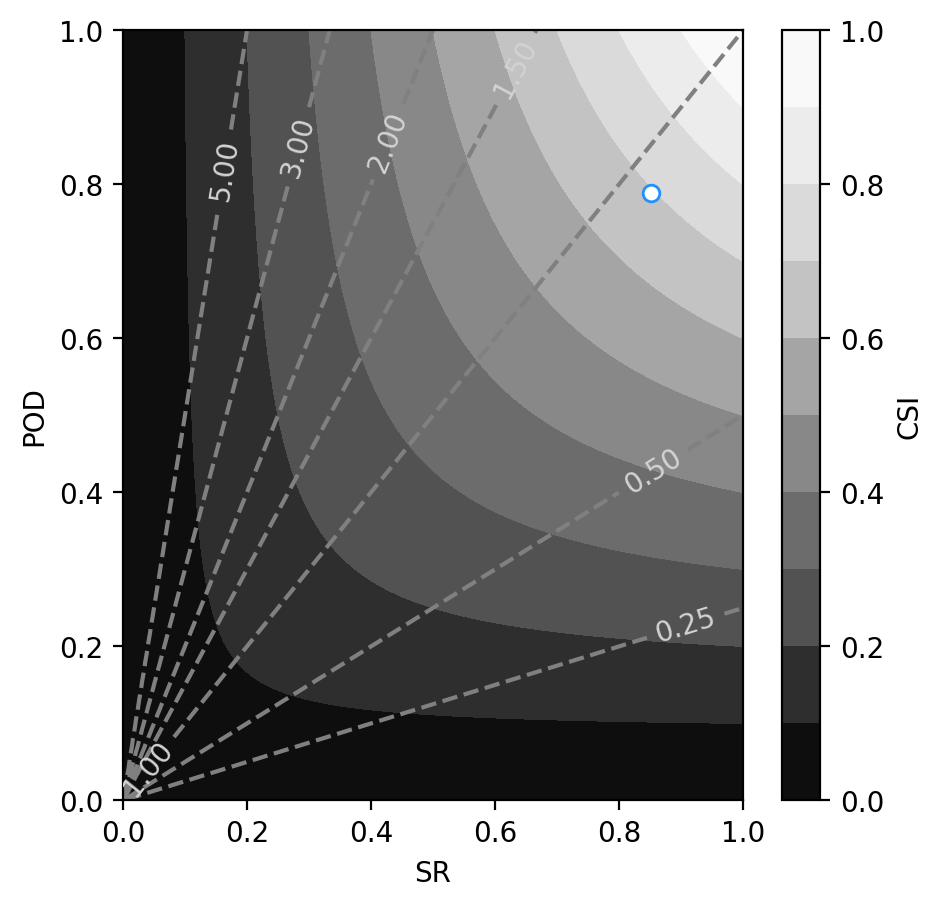

In [14]:
ax = make_performance_diagram_axis()
ax.plot(sr, pod, "o", color="dodgerblue", markerfacecolor="w")

パフォーマンスダイアグラム上でのモデルの性能がどこに位置するかプロットできました。
このモデルは POD、SR ともに大きく、対角線に近い位置に位置して偏りが小さいよいモデルであることが分かります。


### Step 6: 学習したモデルの保存

保存の仕方はいろいろありますがこのノートではビルトインパッケージである `pickle` を使ってみます。

#### 補足

元ノートでは [joblib](https://joblib.readthedocs.io/en/stable/) の使い方も紹介されていますが、
新しいバージョンの pickle は圧縮率も読み込み速度も向上しているのでビルトインパッケージである pickle を使うことにします。


In [15]:
import pickle
from pathlib import Path

save_dir = Path("../datasets/sklearnmodels/classification/onefeature/")
save_file = save_dir / "LogisticRegression.pkl"
if not save_dir.exists():
    save_dir.mkdir(parents=True)
with open(save_file, "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

保存したモデルをロードしてみましょう。


In [16]:
import pickle

save_dir = Path("../datasets/sklearnmodels/classification/onefeature/")
save_file = save_dir / "LogisticRegression.pkl"

with open(save_file, "rb") as f:
    model = pickle.load(f)
print(model)

LogisticRegression()


次のノートでは回帰問題を解いてみます。このまま分類問題について先に続けて学習を進めたい場合はノート 6 に進んでください。
